In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torch.nn.functional as F

from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

import os

print(os.getcwd()) # dosya yolunu ver
%run ../Model.ipynb
%run ../Dataset.ipynb


plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

/arf/home/tunal/ondemand/PhD Thesis Starting/01_SON/Tik-4/Tez/06-Cifar_10/02-UAE_for_Cifar_10


In [6]:
# Dataset
test_dataset = CIFAR10Dataset(mode='test')
# DataLoader
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

# Evaluation

In [7]:
# "results" klasörünü oluştur (zaten varsa hata vermez)
os.makedirs("results", exist_ok=True)

name = 'results/UAE_Cifar_10'
# model_eval = torch.load(name + '.model', weights_only=False, map_location='cpu') # gpu da model eğittiysen cpu da bu şekilde çalışır
model_eval = torch.load(name + '.model', weights_only=False, map_location='cpu')
model_eval.eval()

To_Uniform(
  (encoder): SimpleEncoder(
    (conv1): Conv2d(3, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(256, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): ReLU()
      (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Linear(in_features=512, out_features=256, bias=True)
      (4): 

# MSE on Test Set

In [4]:
X_test, y_test = next(iter(test_loader))

# Test verisini modele ver
with torch.no_grad():
    z, x_hat = model_eval(X_test)   # X_test[:] yazman ile aynı

# MSE Loss nesnesi
mse_loss = nn.MSELoss()

# Ortalama MSE hesapla
mse = mse_loss(x_hat, X_test)

print("Test MSE:", mse.item())

# results klasörünü oluştur
os.makedirs("results", exist_ok=True)

# Dosyaya yaz
file_path = "results/test_mse.txt"
with open(file_path, "w") as f:
    f.write(f"Test MSE: {mse.item()}\n")

print(f"Test MSE results/ klasörüne kaydedildi: {file_path}")

Test MSE: 0.004622067790478468
Test MSE results/ klasörüne kaydedildi: results/test_mse.txt


In [4]:
from torchsummary import summary
summary(model_eval, input_size=(3,32,32))

Layer (type:depth-idx)                   Param #
├─SimpleEncoder: 1-1                     --
|    └─Conv2d: 2-1                       14,336
|    └─BatchNorm2d: 2-2                  1,024
|    └─Conv2d: 2-3                       2,097,408
|    └─BatchNorm2d: 2-4                  512
|    └─Conv2d: 2-5                       1,048,832
|    └─BatchNorm2d: 2-6                  512
|    └─Conv2d: 2-7                       262,208
|    └─BatchNorm2d: 2-8                  128
|    └─Sequential: 2-9                   --
|    |    └─Linear: 3-1                  524,800
|    |    └─ReLU: 3-2                    --
|    |    └─BatchNorm1d: 3-3             1,024
|    |    └─Linear: 3-4                  131,328
|    |    └─Sigmoid: 3-5                 --
├─SimpleDecoder: 1-2                     --
|    └─Sequential: 2-10                  --
|    |    └─Linear: 3-6                  131,584
|    |    └─ReLU: 3-7                    --
|    |    └─Linear: 3-8                  525,312
|    └─ConvTranspos

Layer (type:depth-idx)                   Param #
├─SimpleEncoder: 1-1                     --
|    └─Conv2d: 2-1                       14,336
|    └─BatchNorm2d: 2-2                  1,024
|    └─Conv2d: 2-3                       2,097,408
|    └─BatchNorm2d: 2-4                  512
|    └─Conv2d: 2-5                       1,048,832
|    └─BatchNorm2d: 2-6                  512
|    └─Conv2d: 2-7                       262,208
|    └─BatchNorm2d: 2-8                  128
|    └─Sequential: 2-9                   --
|    |    └─Linear: 3-1                  524,800
|    |    └─ReLU: 3-2                    --
|    |    └─BatchNorm1d: 3-3             1,024
|    |    └─Linear: 3-4                  131,328
|    |    └─Sigmoid: 3-5                 --
├─SimpleDecoder: 1-2                     --
|    └─Sequential: 2-10                  --
|    |    └─Linear: 3-6                  131,584
|    |    └─ReLU: 3-7                    --
|    |    └─Linear: 3-8                  525,312
|    └─ConvTranspos

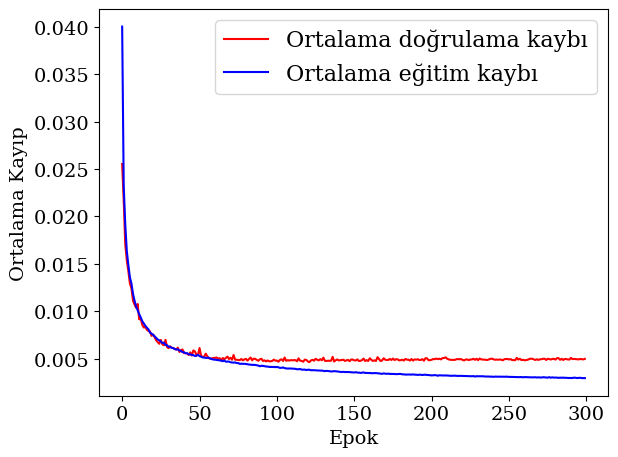

In [102]:
# Kayıpları yükle
losses = np.loadtxt("results/losses.csv", delimiter=",", skiprows=1)
train_losses = losses[:, 0]
val_losses = losses[:, 1]

# Grafik oluştur
plt.plot(val_losses, label="Ortalama doğrulama kaybı", c="red")
plt.plot(train_losses, label="Ortalama eğitim kaybı", c="blue")

plt.xlabel("Epok")
plt.ylabel("Ortalama Kayıp")
plt.legend(loc='upper right', fontsize=16)

plt.tight_layout()
plt.savefig("results/average_losses_per_epoch.pdf")
plt.show()

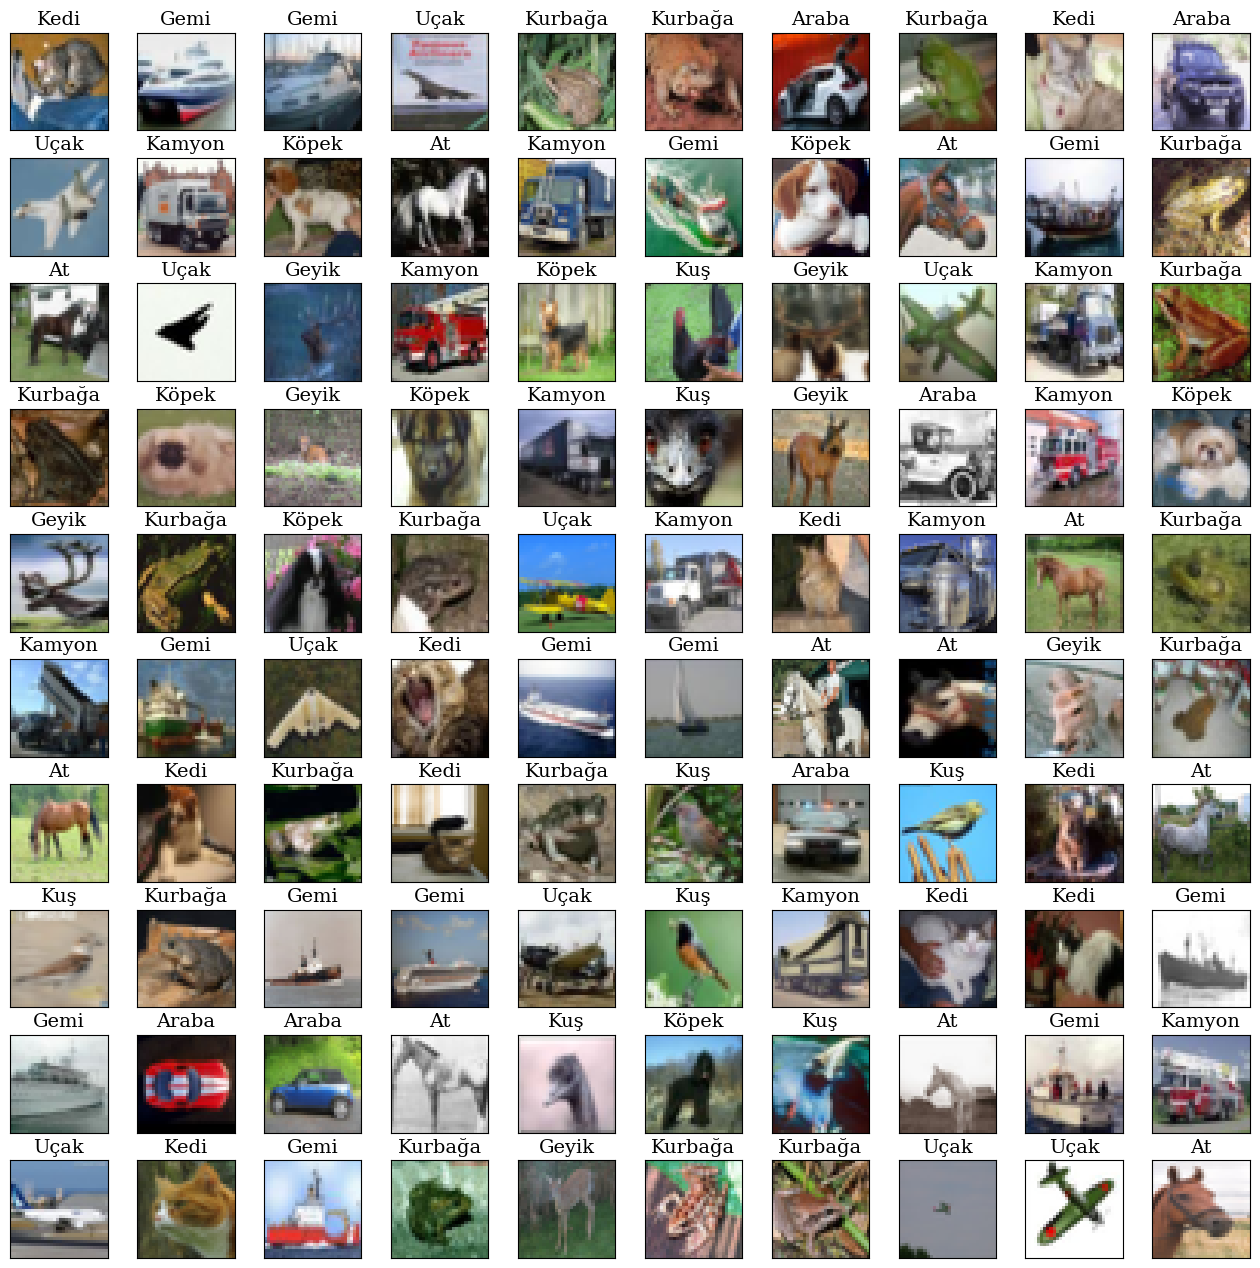

In [101]:
X_test, y_test = next(iter(test_loader))

classes = ['Uçak', 'Araba', 'Kuş', 'Kedi', 'Geyik',
           'Köpek', 'Kurbağa', 'At', 'Gemi', 'Kamyon']

fig, axs = plt.subplots(10, 10, figsize=(16, 16), sharex=True, sharey=True,
                        subplot_kw={'xticks': [], 'yticks': []},
                        gridspec_kw=dict(hspace=0.2, wspace=0.3))

for i in range(10):
    for j in range(10):
        idx = i * 10 + j
        axs[i, j].imshow(X_test[idx].reshape(3, 32, 32).permute(1, 2, 0).detach().numpy())
        axs[i, j].set_title(f'{classes[y_test[idx]]}', fontsize=14)

plt.savefig('results/cifar_10_original_test_verisi.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

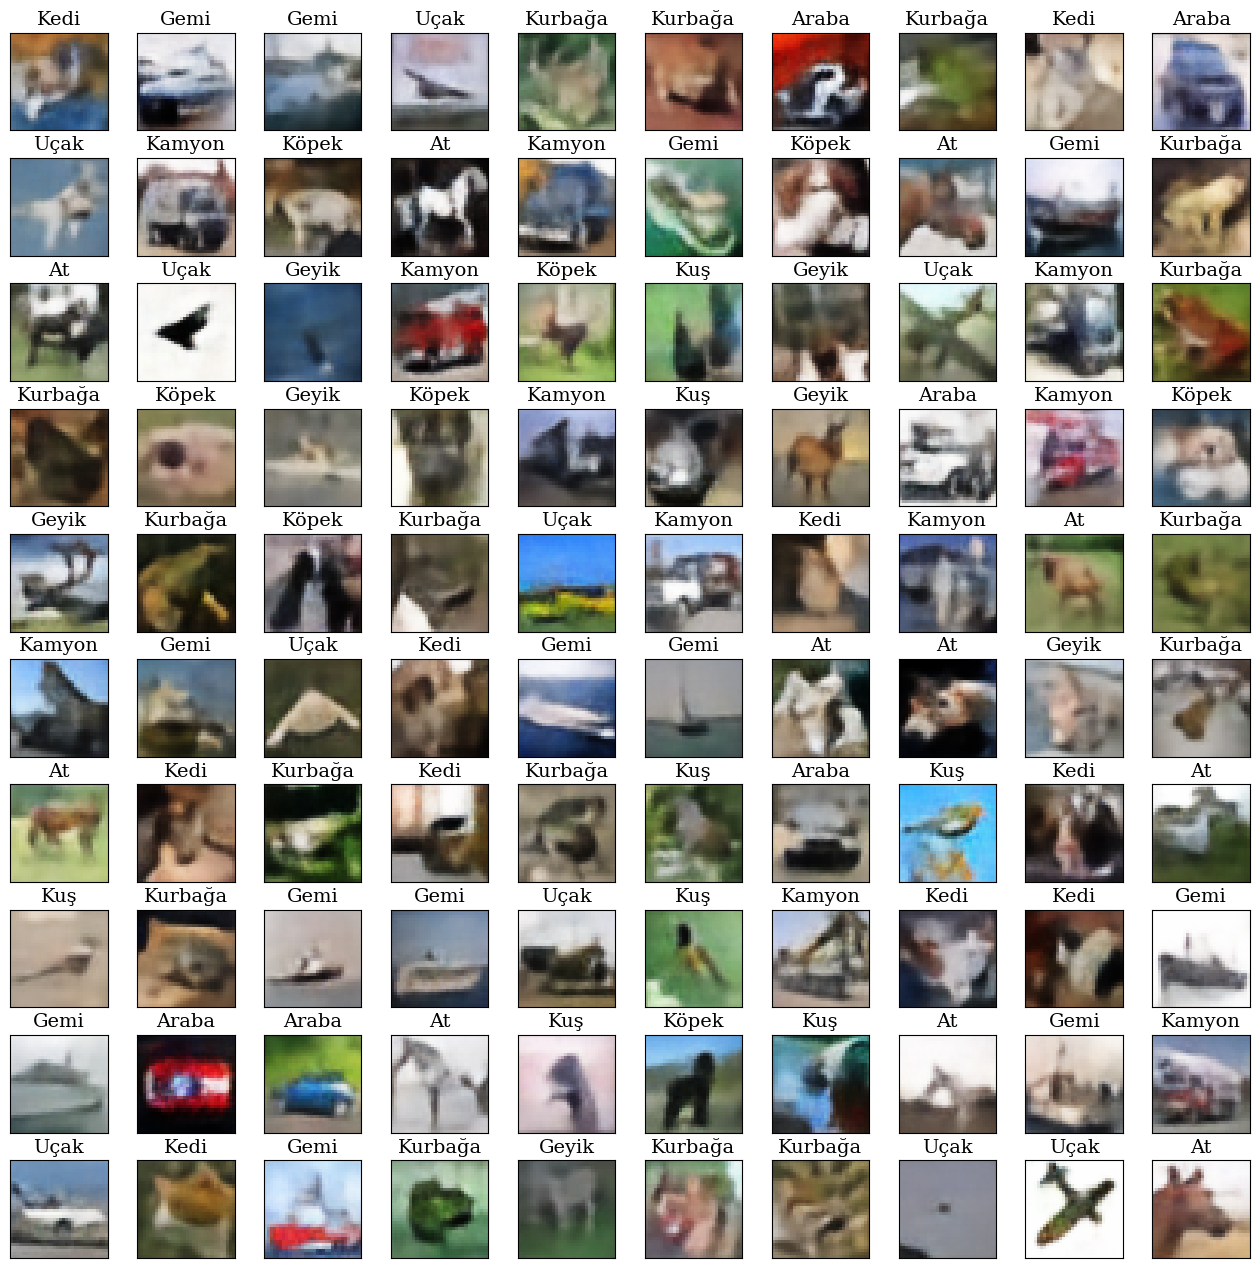

In [7]:
# Tahmin
z, x_hat = model_eval(X_test[:100])

classes = ['Uçak', 'Araba', 'Kuş', 'Kedi', 'Geyik',
           'Köpek', 'Kurbağa', 'At', 'Gemi', 'Kamyon']

fig, axs = plt.subplots(10, 10, figsize=(16, 16), sharex=True, sharey=True,
                        subplot_kw={'xticks': [], 'yticks': []},
                        gridspec_kw=dict(hspace=0.2, wspace=0.3))

for i in range(10):
    for j in range(10):
        idx = i * 10 + j
        axs[i, j].imshow(x_hat[idx].reshape(3, 32, 32).permute(1, 2, 0).detach().numpy(), interpolation='nearest')
        axs[i, j].set_title(f'{classes[y_test[idx]]}', fontsize=14)

plt.savefig('results/cifar10_test_verisi_production.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

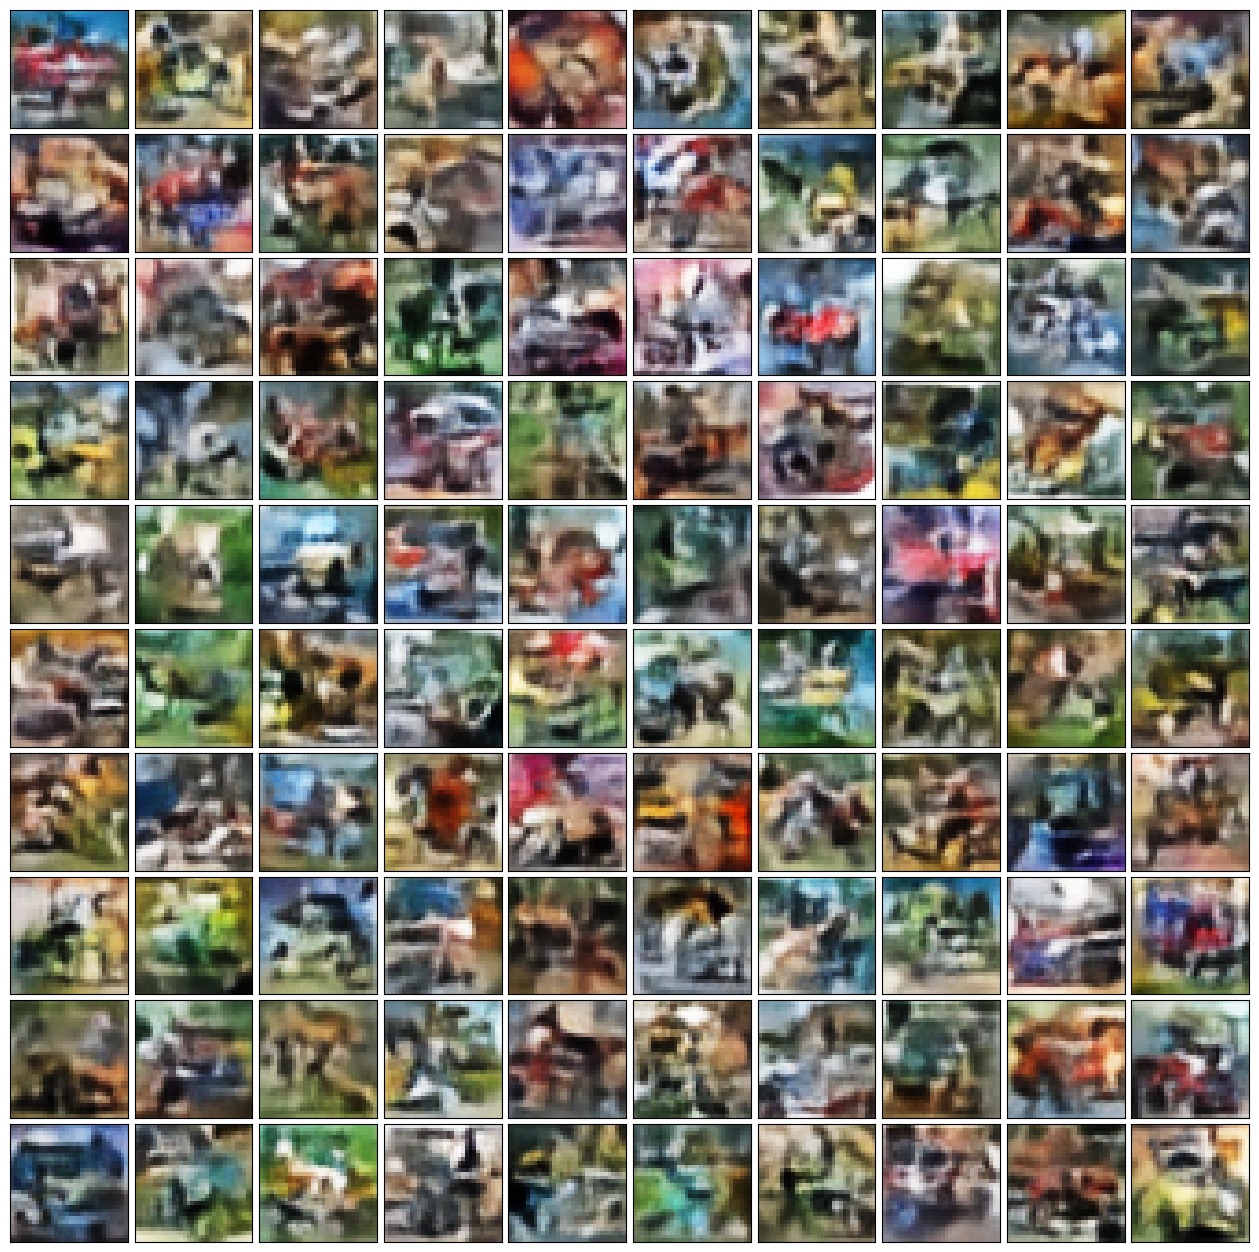

In [8]:
# uniform latent dağılımdan örnek al
uniform_dist = torch.distributions.uniform.Uniform(low=torch.zeros(256), high=torch.ones(256))
latent_samples = uniform_dist.sample((100,))  # 5x10 grid için 50 örnek

# Decode et
x_hat = model_eval.decode(latent_samples).view(-1, 3, 32, 32)

# Görselleştir
fig, axs = plt.subplots(10, 10, figsize=(16, 16), sharex=True, sharey=True,
                        subplot_kw={'xticks': [], 'yticks': []},
                        gridspec_kw=dict(hspace=0.05, wspace=0.05))

for i, ax in enumerate(axs.flat):
    img = x_hat[i].reshape(3, 32, 32).permute(1, 2, 0).detach().numpy()
    ax.imshow(img, interpolation='nearest')

plt.savefig('./results/cifar10_veri_uretimi_from_latent.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1, dpi=300)
plt.show()

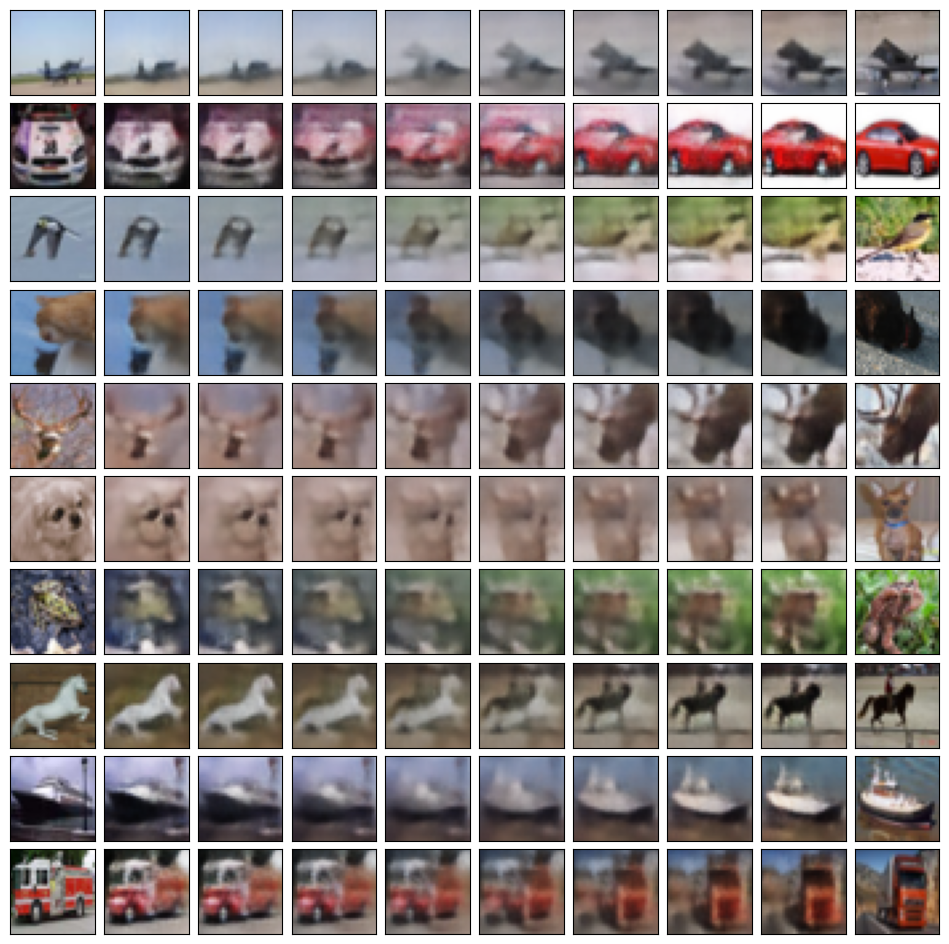

In [9]:
# 3. class_indices sözlüğü
class_indices = {label.item(): (y_test == label).nonzero(as_tuple=True)[0] for label in y_test.unique()}

# 5. Interpolasyon fonksiyonu
def cifar10_interpolation_same_class(model, X_tensor, y_tensor, class_indices, device='cpu'):
    model.to(device)
    model.eval()

    fig, axes = plt.subplots(10, 10, figsize=(12, 12),
                             subplot_kw={'xticks': [], 'yticks': []},
                             gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

    for row in range(10):
        # Aynı sınıftan 2 örnek seç (sınıf = row)
        label = row
        indices = class_indices[label]
        idx1, idx2 = np.random.choice(indices.cpu(), size=2, replace=False)
        img1 = X_tensor[idx1].unsqueeze(0).to(device)  # [1, 3, 32, 32]
        img2 = X_tensor[idx2].unsqueeze(0).to(device)

        with torch.no_grad():
            z1 = model.encoder(img1)
            z2 = model.encoder(img2)
            decoded_img1 = model.decoder(z1).squeeze(0).cpu()
            decoded_img2 = model.decoder(z2).squeeze(0).cpu()

        # 1. Görsel: orijinal img1
        axes[row, 0].imshow(img1.squeeze(0).cpu().permute(1, 2, 0).numpy())

        # 2. Görsel: decoded img1
        axes[row, 1].imshow(decoded_img1.permute(1, 2, 0).numpy())

        # 6 interpolasyon
        for i in range(6):
            alpha = (i + 1) / 7.0
            z_interp = (1 - alpha) * z1 + alpha * z2
            interp_img = model.decoder(z_interp).squeeze(0).cpu()
            axes[row, 2 + i].imshow(interp_img.permute(1, 2, 0).detach().numpy())

        # 9. Görsel: decoded img2
        axes[row, 8].imshow(decoded_img2.permute(1, 2, 0).numpy())

        # 10. Görsel: orijinal img2
        axes[row, 9].imshow(img2.squeeze(0).cpu().permute(1, 2, 0).numpy())

    plt.savefig('./results/cifar10_same_class_interpolation_grid.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1, dpi=300)
    plt.show()

cifar10_interpolation_same_class(model_eval, X_test, y_test, class_indices, device='cpu')

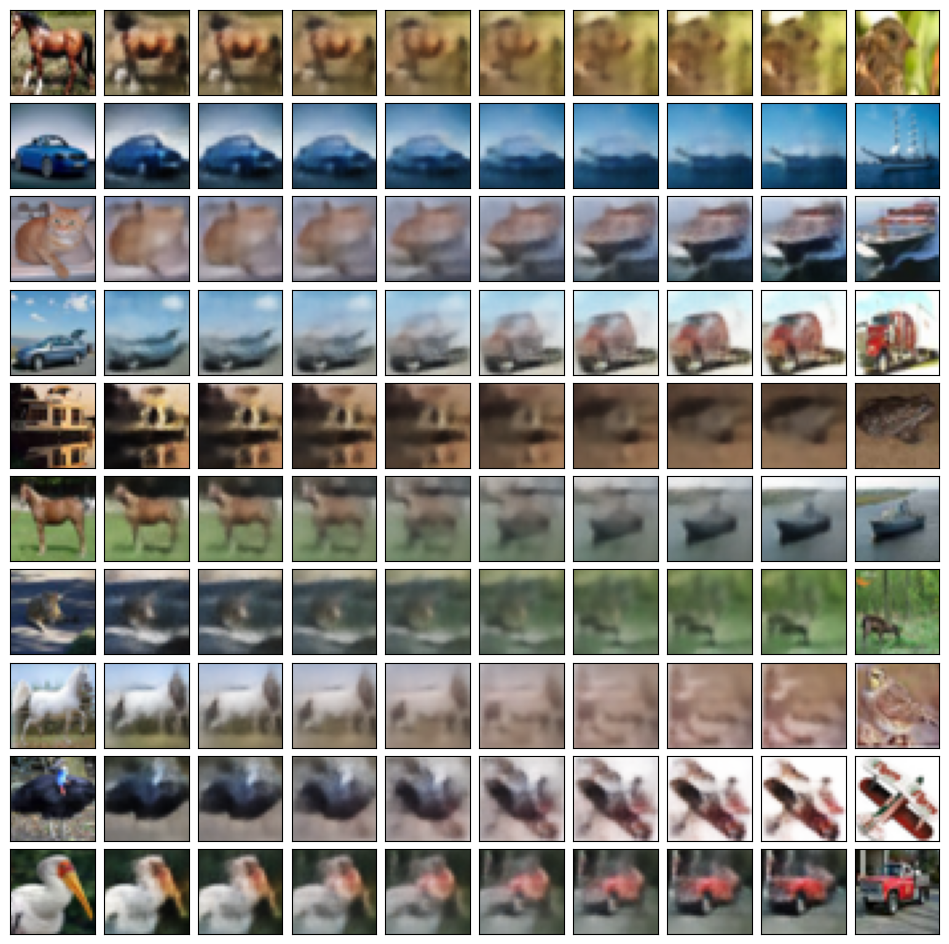

In [10]:
# Farklı sınıflarda interpolasyon
def cifar10_interpolation_grid(model, data_tensor, labels_tensor, device='cpu'):
    model.to(device)
    model.eval()

    fig, axes = plt.subplots(10, 10, figsize=(12, 12),
                             subplot_kw={'xticks': [], 'yticks': []},
                             gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

    labels_np = labels_tensor.cpu().numpy()

    for row in range(10):
        # Farklı sınıflardan iki örnek seç
        while True:
            idx1 = torch.randint(0, len(data_tensor), (1,)).item()
            idx2 = torch.randint(0, len(data_tensor), (1,)).item()
            if labels_np[idx1] != labels_np[idx2]:
                break

        img1 = data_tensor[idx1].unsqueeze(0).to(device)  # [1, 3, 32, 32]
        img2 = data_tensor[idx2].unsqueeze(0).to(device)

        with torch.no_grad():
            z1 = model.encoder(img1)
            z2 = model.encoder(img2)
            decoded_img1 = model.decoder(z1).squeeze(0).cpu()
            decoded_img2 = model.decoder(z2).squeeze(0).cpu()

        # 1. Görsel: orijinal img1
        axes[row, 0].imshow(img1.squeeze(0).cpu().permute(1, 2, 0).numpy())

        # 2. Görsel: decoded img1
        axes[row, 1].imshow(decoded_img1.permute(1, 2, 0).numpy())

        # 6 interpolasyon
        for i in range(6):
            alpha = (i + 1) / 7.0
            z_interp = (1 - alpha) * z1 + alpha * z2
            interp_img = model.decoder(z_interp).squeeze(0).cpu()
            axes[row, 2 + i].imshow(interp_img.permute(1, 2, 0).detach().numpy())

        # 9. Görsel: decoded img2
        axes[row, 8].imshow(decoded_img2.permute(1, 2, 0).numpy())

        # 10. Görsel: orijinal img2
        axes[row, 9].imshow(img2.squeeze(0).cpu().permute(1, 2, 0).numpy())

    plt.savefig('./results/cifar10_different_class_interpolation_grid.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1, dpi=300)
    plt.show()

cifar10_interpolation_grid(model_eval, X_test, y_test, device='cpu')

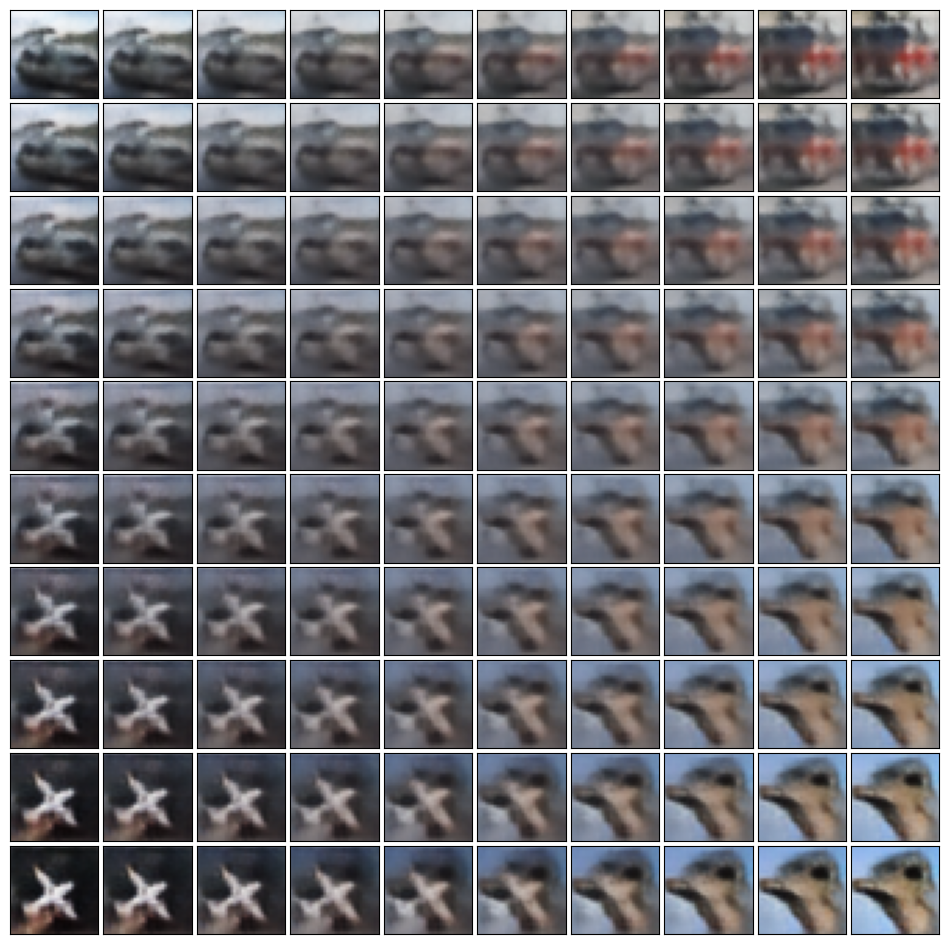

In [100]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict

def bilinear_interpolation(z_tl, z_tr, z_bl, z_br, x, y):
    """x: yatay eksende 0-1, y: düşey eksende 0-1"""
    return (
        (1 - x) * (1 - y) * z_tl +
        x * (1 - y) * z_tr +
        (1 - x) * y * z_bl +
        x * y * z_br
    )

def cifar10_corner_interpolation(model, data_tensor, labels_tensor, device='cpu'):
    model.to(device)
    model.eval()

    original_classes = ['Uçak', 'Araba', 'Kuş', 'Kedi', 'Geyik',
           'Köpek', 'Kurbağa', 'At', 'Gemi', 'Kamyon']
    labels_np = labels_tensor.cpu().numpy()
    class_indices = defaultdict(list)

    for idx, label in enumerate(labels_np):
        class_indices[label].append(idx)

    classes = list(class_indices.keys())
    selected_classes = np.random.choice(classes, size=4, replace=False)

    # 4 farklı sınıftan birer örnek seç (indeks ve etiket)
    idx_tl = np.random.choice(class_indices[selected_classes[0]])
    idx_tr = np.random.choice(class_indices[selected_classes[1]])
    idx_bl = np.random.choice(class_indices[selected_classes[2]])
    idx_br = np.random.choice(class_indices[selected_classes[3]])

    # Köşe bilgileri
    corner_info = {
        'Top-Left':  (idx_tl, selected_classes[0]),
        'Top-Right': (idx_tr, selected_classes[1]),
        'Bottom-Left': (idx_bl, selected_classes[2]),
        'Bottom-Right': (idx_br, selected_classes[3])
    }

    # TXT dosyasına yaz
    os.makedirs("results", exist_ok=True)
    with open("results/corner_cifar10_info.txt", "w") as f:
        f.write("Köşe interpolasyonu için seçilen CIFAR10 örnekleri:\n\n")
        for corner, (idx, label) in corner_info.items():
            f.write(f"{corner}: indeks = {idx}, sınıf = {original_classes[label]}\n")

    # Görselleri al
    img_tl = data_tensor[idx_tl].unsqueeze(0).to(device)
    img_tr = data_tensor[idx_tr].unsqueeze(0).to(device)
    img_bl = data_tensor[idx_bl].unsqueeze(0).to(device)
    img_br = data_tensor[idx_br].unsqueeze(0).to(device)

    with torch.no_grad():
        z_tl = model.encoder(img_tl)
        z_tr = model.encoder(img_tr)
        z_bl = model.encoder(img_bl)
        z_br = model.encoder(img_br)

    # Görselleştirme için grid oluştur
    fig, axes = plt.subplots(10, 10, figsize=(12, 12),
                             subplot_kw={'xticks': [], 'yticks': []},
                             gridspec_kw={'wspace': 0.05, 'hspace': 0.05})

    for i in range(10):
        for j in range(10):
            x = j / 9.0  # yatay interpolasyon katsayısı
            y = i / 9.0  # düşey interpolasyon katsayısı
            z_interp = bilinear_interpolation(z_tl, z_tr, z_bl, z_br, x, y)
            with torch.no_grad():
                img = model.decoder(z_interp).squeeze(0).cpu()
                axes[i, j].imshow(img.permute(1, 2, 0).numpy())

    plt.savefig('./results/cifar10_corner_interpolation.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1, dpi=300)
    plt.show()

cifar10_corner_interpolation(model_eval, X_test, y_test, device='cpu')

# makale için ingilizceye çevirdim

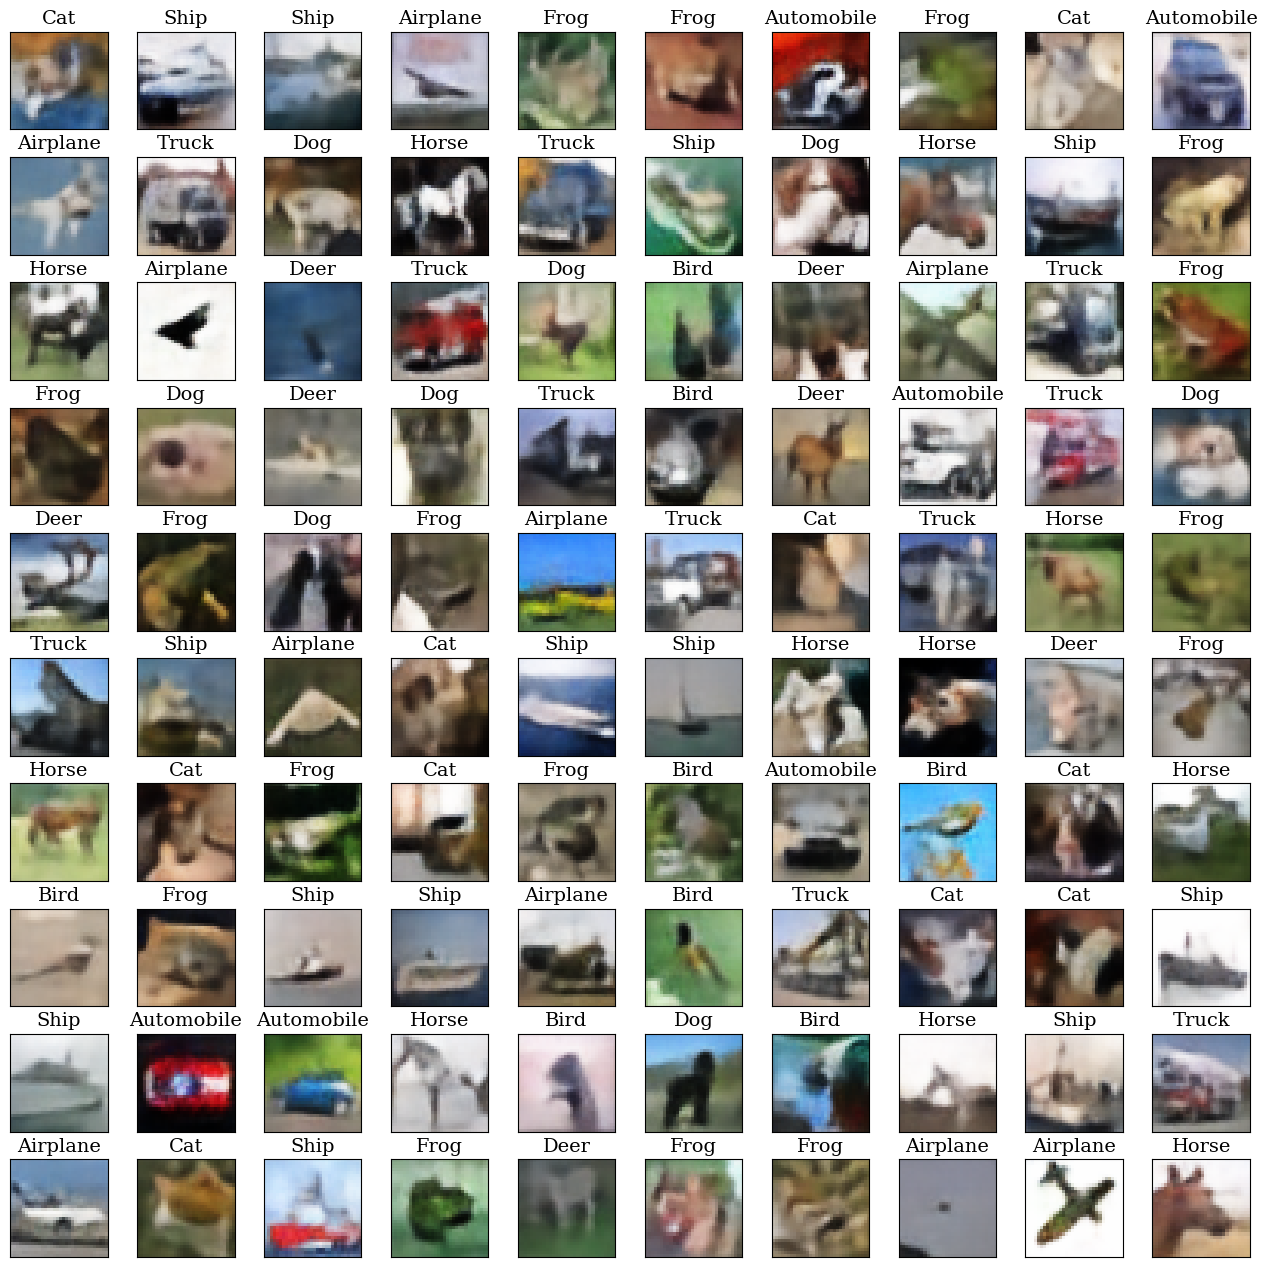

In [8]:
X_test, y_test = next(iter(test_loader))

# Tahmin
z, x_hat = model_eval(X_test[:100])

classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
           'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

fig, axs = plt.subplots(10, 10, figsize=(16, 16), sharex=True, sharey=True,
                        subplot_kw={'xticks': [], 'yticks': []},
                        gridspec_kw=dict(hspace=0.2, wspace=0.3))

for i in range(10):
    for j in range(10):
        idx = i * 10 + j
        axs[i, j].imshow(x_hat[idx].reshape(3, 32, 32).permute(1, 2, 0).detach().numpy(), interpolation='nearest')
        axs[i, j].set_title(f'{classes[y_test[idx]]}', fontsize=14)

plt.savefig('results/cifar10_test_verisi_production_label.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()